In [68]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from pylab import rcParams
import matplotlib.pyplot as plt

In [2]:
def getFiles(file_list, which):
    datapath = "./../2022"
    for root, dirs, files in os.walk(datapath):
        for file in files:
            if ('csv' in file and not ("Movement" in file) and (file[0] == which)):
                file_list.append(os.path.join(root, file))
                
Thingy_list = []
Respect_list = []

getFiles(Thingy_list, 'T')
getFiles(Respect_list, 'R')

print(len(Thingy_list), len(Respect_list))

1014 1014


In [3]:
def all_csv_to_dataframe(dataframe, thingy_list, respect_list):
    for i in range(len(thingy_list)):
        thingy_file = thingy_list[i]
        respect_file = respect_list[i]
        if thingy_file[25:43] == respect_file[26:44]:
            
            new_thingy = pd.read_csv(thingy_file)
            new_thingy = new_thingy.rename(columns=
                             {'accel_x'      :'T_accel_x',
                              'accel_y'      :'T_accel_y',
                              'accel_z'      :'T_accel_z',
                              'gyro_x'       :'T_gyro_x' ,
                              'gyro_y'       :'T_gyro_y' ,
                              'gyro_z'       :'T_gyro_z' ,
                              'activity_code':'T_activity_code'})
            new_respect = pd.read_csv(respect_file)
            new_respect = new_respect.rename(columns=
                             {'accel_x'      :'R_accel_x',
                              'accel_y'      :'R_accel_y',
                              'accel_z'      :'R_accel_z',
                              'gyro_x'       :'R_gyro_x' ,
                              'gyro_y'       :'R_gyro_y' ,
                              'gyro_z'       :'R_gyro_z' ,
                              'activity_code':'R_activity_code'})
            
            new_dataframe = pd.concat([new_thingy, new_respect], axis=1)
            dataframe = pd.concat([dataframe, new_dataframe])
            
    return dataframe

dataframe = pd.DataFrame()
dataframe = all_csv_to_dataframe(dataframe, Thingy_list, Respect_list)

In [4]:
# Somehow there are 6873 and 664 null activity code/type in thingy and respect
print(dataframe['T_activity_code'].isnull().sum(), dataframe['R_activity_code'].isnull().sum())
dataframe = dataframe.dropna()
print(dataframe['T_activity_code'].isnull().sum(), dataframe['R_activity_code'].isnull().sum())

print(pd.unique(dataframe['T_activity_code']))
print(pd.unique(dataframe['R_activity_code']))

6873 664
0 0
[ 12.  13.  31.   7.   2.   8.   6.  11.   5.   4.   0. 100.   1.]
[ 12.  13.  31.   7.   2.   8.   6.  11.   5.   4.   0. 100.   1.]


In [5]:
# Proof of all Thingy acitivy code are the same as all Respect activity code
not_same = dataframe['T_activity_code'] != dataframe['R_activity_code']
np.where(not_same)

(array([], dtype=int64),)

In [47]:
def create_dataset(dataframe, data_columns, label_column, time_steps=1, step=1):
    XX, YY = [], []
    raw_x = dataframe[data_columns]
    raw_y = dataframe[label_column]
    
    for i in range(0, len(raw_x) - time_steps, step):
        label = raw_y.iloc[i].values
        value = raw_x.iloc[i]
        same = True
        for j in range(i + 1, i + time_steps):
            if label != raw_y.iloc[j].values:
                same = False
                break
        if not same:
            continue
        else:
            value = raw_x.iloc[i: i + time_steps]
        XX.append(value)
        YY.append(label)
        
    X = np.array(XX)
    Y = np.array(YY)
    return X, Y

Thingy_columns = ['T_accel_x', 'T_accel_y', 'T_accel_z', 'T_gyro_x', 'T_gyro_y', 'T_gyro_z', 'mag_x', 'mag_y', 'mag_z']
Thingy_label = ['T_activity_code']
Respect_columns = ['R_accel_x', 'R_accel_y', 'R_accel_z', 'R_gyro_x', 'R_gyro_y', 'R_gyro_z']
Respect_label = ['R_activity_code']

In [59]:
# Thingy data only
X_Thingy, y_Thingy = create_dataset(dataframe, Thingy_columns, Thingy_label, 50, 10)
X_train_Thingy, X_test_Thingy, y_train_Thingy, y_test_Thingy = train_test_split(X_Thingy, y_Thingy, random_state=111)

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder = encoder.fit(y_train_Thingy)
y_train_Thingy = encoder.transform(y_train_Thingy)
y_test_Thingy  = encoder.transform(y_test_Thingy)
print(X_train_Thingy.shape, X_test_Thingy.shape, y_train_Thingy.shape, y_test_Thingy.shape)

(12864, 50, 9) (4289, 50, 9) (12864, 13) (4289, 13)


In [48]:
# Respect data only
X_Respect, y_Respect = create_dataset(dataframe, Respect_columns, Respect_label, 50, 10)
X_train_Respect, X_test_Respect, y_train_Respect, y_test_Respect = train_test_split(X_Respect, y_Respect, random_state=111)

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder = encoder.fit(y_train_Respect)
y_train_Respect = encoder.transform(y_train_Respect)
y_test_Respect  = encoder.transform(y_test_Respect)
print(X_train_Respect.shape, X_test_Respect.shape, y_train_Respect.shape, y_test_Respect.shape)

(12864, 50, 6) (4289, 50, 6) (12864, 13) (4289, 13)


In [60]:
# All data
X, y = create_dataset(dataframe, Thingy_columns + Respect_columns, Thingy_label, 50, 10)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=111)

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder = encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test  = encoder.transform(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(12864, 50, 15) (4289, 50, 15) (12864, 13) (4289, 13)


In [62]:
def create_model(X, y):
    n_timesteps, n_features, n_outputs = X.shape[1], X.shape[2], y.shape[1]
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(tf.keras.layers.Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # train model
    model.fit(X, y, epochs=30, batch_size=32, verbose=1)
    return model

respeck_model = create_model(X_train_Respect, y_train_Respect)
thingy_model = create_model(X_train_Thingy, y_train_Thingy)
all_model = create_model(X_train, y_train)

Epoch 1/30
402/402 [==============================] - 6s 12ms/step - loss: 1.0799 - accuracy: 0.5956
Epoch 2/30
402/402 [==============================] - 4s 11ms/step - loss: 0.5313 - accuracy: 0.7780
Epoch 3/30
402/402 [==============================] - 4s 11ms/step - loss: 0.4146 - accuracy: 0.8337
Epoch 4/30
402/402 [==============================] - 5s 12ms/step - loss: 0.3361 - accuracy: 0.8697
Epoch 5/30
402/402 [==============================] - 5s 11ms/step - loss: 0.2670 - accuracy: 0.8977
Epoch 6/30
402/402 [==============================] - 5s 12ms/step - loss: 0.2122 - accuracy: 0.9179
Epoch 7/30
402/402 [==============================] - 5s 11ms/step - loss: 0.2111 - accuracy: 0.9229
Epoch 8/30
402/402 [==============================] - 5s 11ms/step - loss: 0.1527 - accuracy: 0.9430
Epoch 9/30
402/402 [==============================] - 4s 11ms/step - loss: 0.1298 - accuracy: 0.9530
Epoch 10/30
402/402 [==============================] - 4s 10ms/step - loss: 0.1218 - accura

402/402 [==============================] - 4s 11ms/step - loss: 0.0943 - accuracy: 0.9801
Epoch 22/30
402/402 [==============================] - 5s 11ms/step - loss: 0.0531 - accuracy: 0.9856
Epoch 23/30
402/402 [==============================] - 5s 12ms/step - loss: 0.0340 - accuracy: 0.9908
Epoch 24/30
402/402 [==============================] - 4s 11ms/step - loss: 0.0379 - accuracy: 0.9901
Epoch 25/30
402/402 [==============================] - 4s 11ms/step - loss: 0.0237 - accuracy: 0.9932
Epoch 26/30
402/402 [==============================] - 5s 12ms/step - loss: 0.0166 - accuracy: 0.9951
Epoch 27/30
402/402 [==============================] - 5s 12ms/step - loss: 0.0292 - accuracy: 0.9934
Epoch 28/30
402/402 [==============================] - 4s 11ms/step - loss: 0.0576 - accuracy: 0.9862
Epoch 29/30
402/402 [==============================] - 5s 12ms/step - loss: 0.0954 - accuracy: 0.9846
Epoch 30/30
402/402 [==============================] - 5s 12ms/step - loss: 0.0650 - accuracy:

In [70]:
respeck_results = respeck_model.evaluate(X_test_Respect, y_test_Respect, batch_size=32, verbose=0)
print("test loss, test acc:", respeck_results)

thingy_results = thingy_model.evaluate(X_test_Thingy, y_test_Thingy, batch_size=32, verbose=0)
print("test loss, test acc:", thingy_results)

all_results = all_model.evaluate(X_test, y_test, batch_size=32, verbose=0)
print("test loss, test acc:", all_results)

test loss, test acc: [0.07174436748027802, 0.9764513969421387]
test loss, test acc: [0.035370342433452606, 0.9867101907730103]
test loss, test acc: [0.19739298522472382, 0.9785497784614563]


135/135 [==============================] - 0s 3ms/step


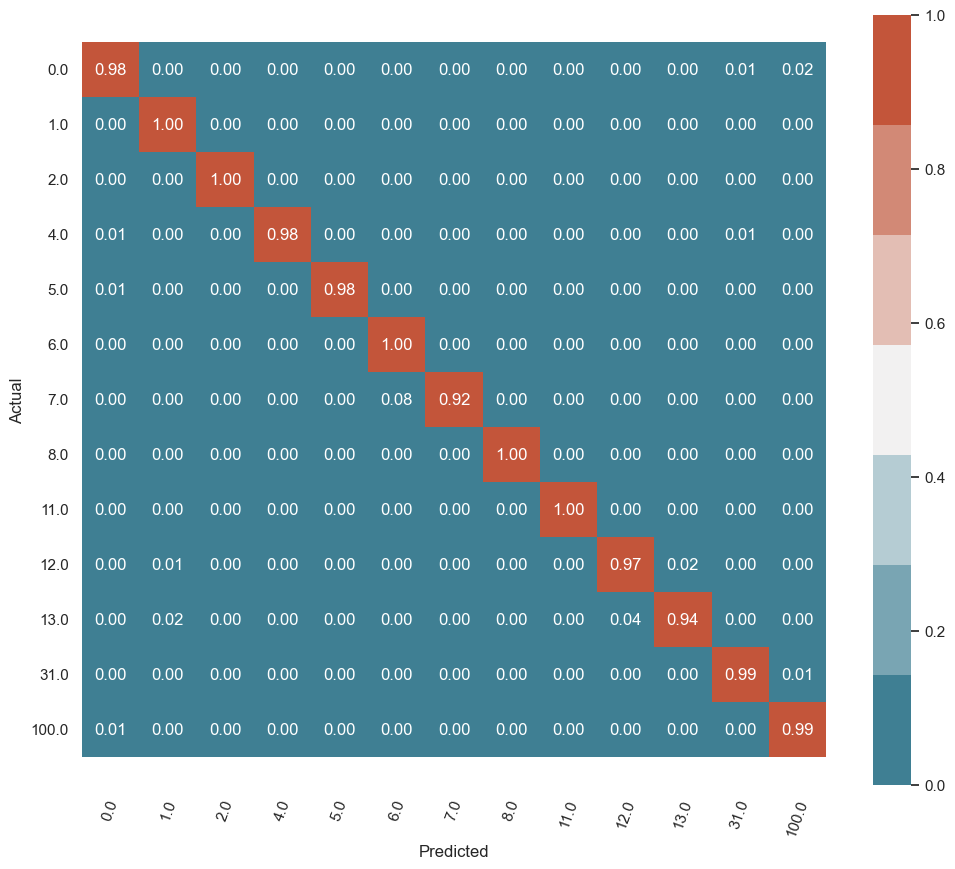

In [69]:
predy = model.predict(X_test_Respect)
# print(predy)
def plot_cm(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    fig, ax = plt.subplots(figsize=(12, 10)) 
    ax = sns.heatmap(
        cm, 
        annot=True, 
        fmt=".2f", 
        cmap=sns.diverging_palette(220, 20, n=7),
        ax=ax
    )

    plt.xticks(rotation=70)
    plt.yticks(rotation=90)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names, rotation=0)
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1)

rcParams['figure.figsize'] = 22, 10

plot_cm(
    encoder.inverse_transform(y_test),
    encoder.inverse_transform(predy),
    encoder.categories_[0]
) 